In [46]:
import pickle
import matplotlib.pyplot as plt
file_location = 'SimulationResults/SensitivityAnalysis/SOBOLAnalysis1747923579/SOBOL_analysis_limited_data_1747923579.pickle'
timestamp = file_location.split('.')[0].split('_')[-1]
with open(file_location, 'rb') as f:
    sensitivity_data = pickle.load(f)


In [81]:
def create_sobol_plot(analyzed, parameter_names, title):
    fig, axs = plt.subplots(len(analyzed), 2, figsize=(10, 10))
    fig.suptitle(f'Total (ST) and First Order (S1) Sobol Sensitivity Analysis \n for {title} Value of Simulation for Phages, Uninfected \n Bacteria, Infected Bacteria, Phages, and Bacteria Sum', fontsize=20)
    list_of_output = ['Resources', 'Uninfected', 'Infected', 'Phages', 'Total Bacteria']
    for i, analyzed_item in enumerate(analyzed):
        St = analyzed_item['ST']
        St_conf = analyzed_item['ST_conf']
        axs[i, 0].bar(parameter_names, St, yerr=St_conf, capsize=5)
        axs[i, 0].set_ylabel('ST', fontsize=14)
        axs[i, 0].set_title(f'ST for {list_of_output[i]}', fontsize=16)
        axs[i, 0].tick_params(axis='y', labelsize=12)
        if i == len(analyzed) - 1:
            axs[i, 0].set_xticks(range(len(parameter_names)))
            axs[i, 0].set_xticklabels(parameter_names, rotation=45, ha='right', fontsize=12)
        else: 
            axs[i, 0].set_xticks([])
        axs[i, 0].grid(True, axis='y', linestyle='--', alpha=0.7)
        axs[i, 0].minorticks_on()
        axs[i, 0].grid(True, which='minor', axis='y', linestyle=':', alpha=0.4)

    for i, analyzed_item in enumerate(analyzed):
        S1 = analyzed_item['S1']
        S1_conf = analyzed_item['S1_conf']
        axs[i, 1].bar(parameter_names, S1, yerr=S1_conf, capsize=5)
        axs[i, 1].set_ylabel('S1', fontsize=14)
        axs[i, 1].set_title(f'S1 for {list_of_output[i]}', fontsize=16)
        axs[i, 1].tick_params(axis='y', labelsize=12)
        if i == len(analyzed) - 1:
            axs[i, 1].set_xticks(range(len(parameter_names)))
            axs[i, 1].set_xticklabels(parameter_names, rotation=45, ha='right', fontsize=12)
        else: 
            axs[i, 1].set_xticks([])
        axs[i, 1].grid(True, axis='y', linestyle='--', alpha=0.7)
        axs[i, 1].minorticks_on()
        axs[i, 1].grid(True, which='minor', axis='y', linestyle=':', alpha=0.4)
        
    fig.tight_layout()
    fig.savefig(f'LatexReport/Images/Plots/Created/SOBOL_analysis_{timestamp}_{title}.png', dpi=300)


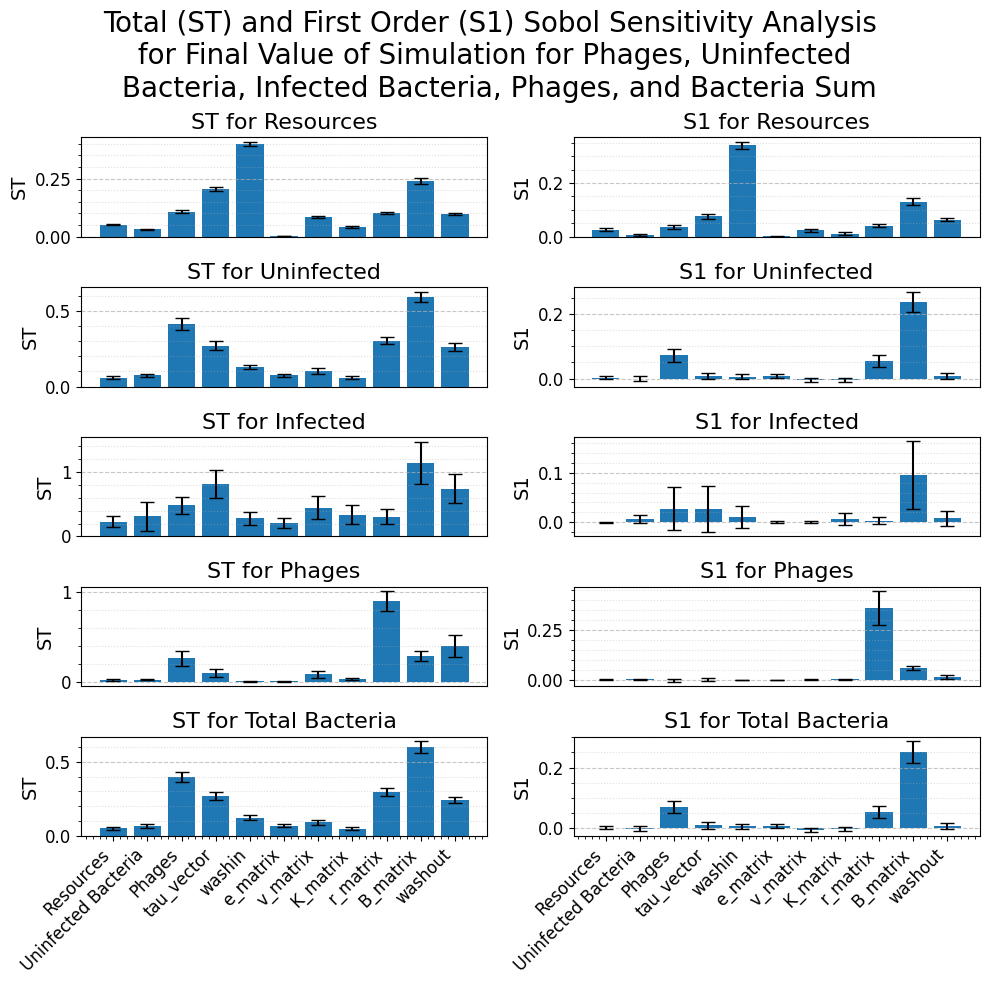

In [82]:
parameter_names = sensitivity_data['parameter_names']
final_analyzed = sensitivity_data['final_analyzed']
create_sobol_plot(final_analyzed, parameter_names, "Final")

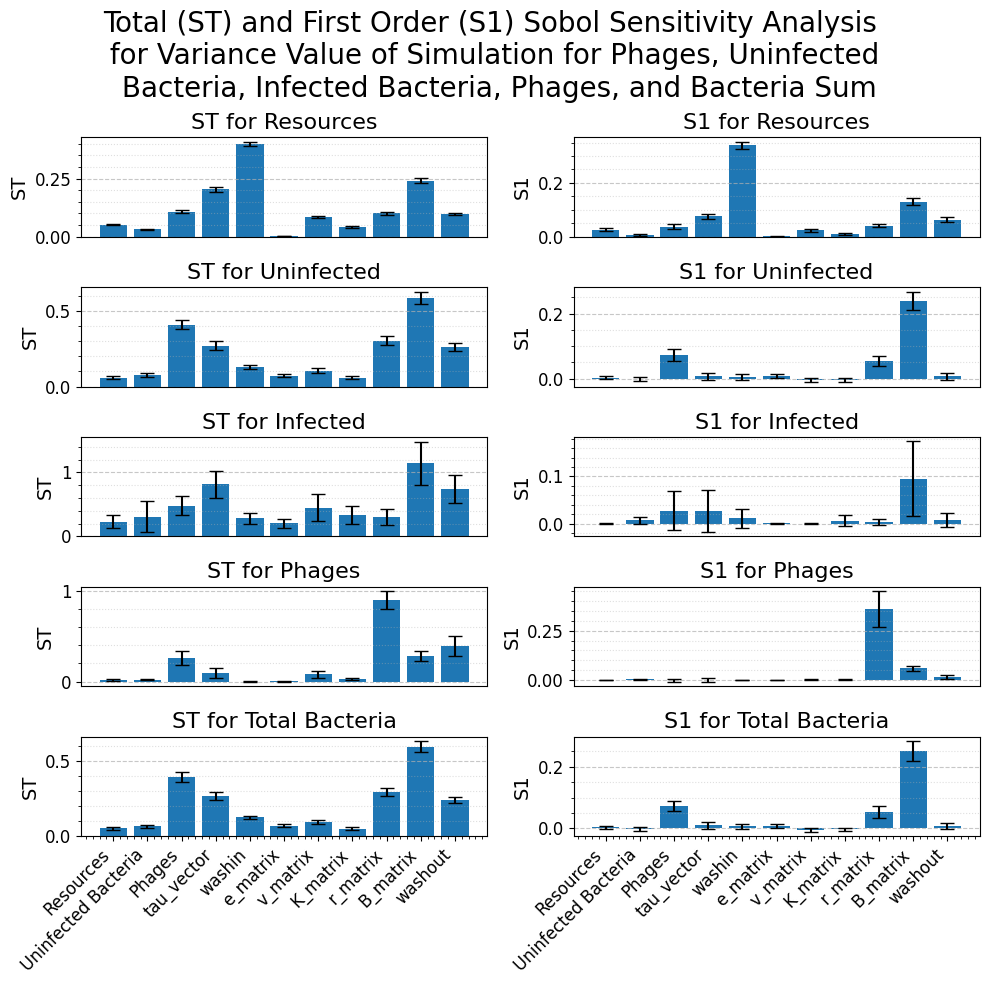

In [83]:
parameter_names = sensitivity_data['parameter_names']
final_analyzed = sensitivity_data['var_analyzed']
create_sobol_plot(final_analyzed, parameter_names, "Variance")

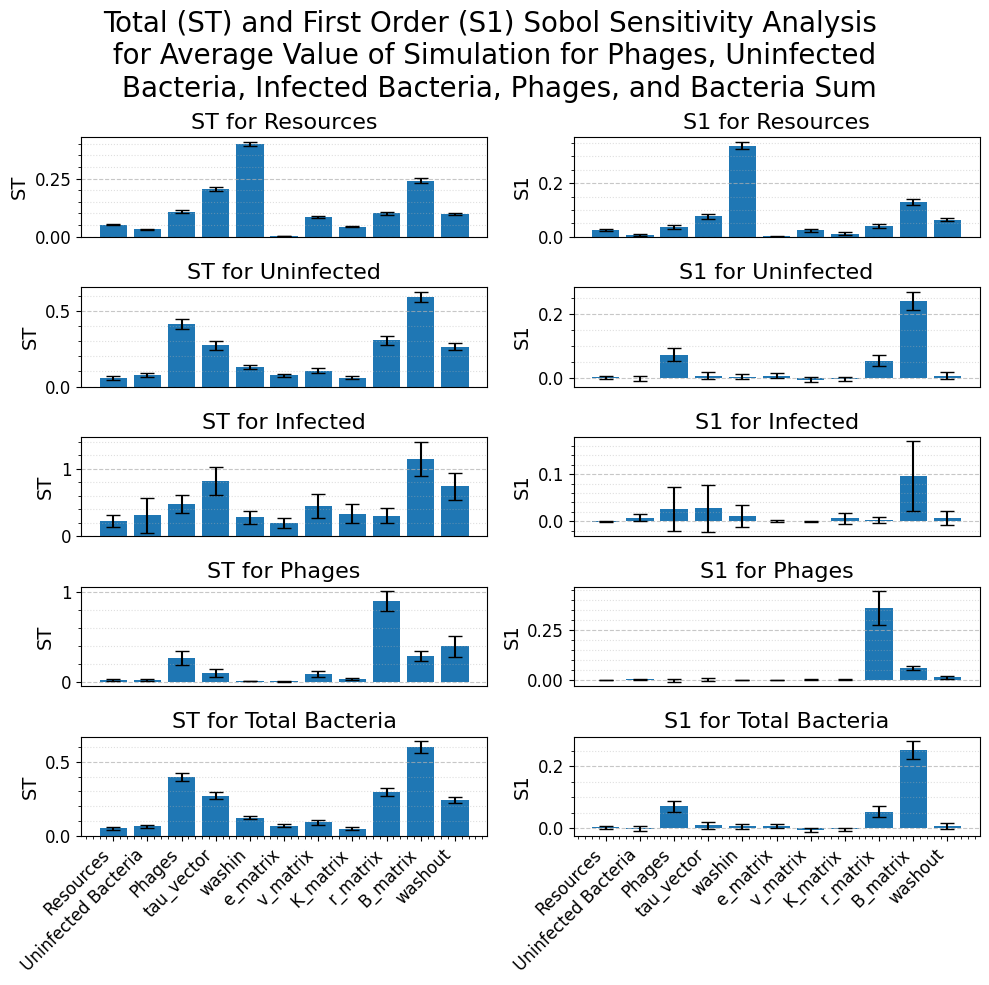

In [84]:
parameter_names = sensitivity_data['parameter_names']
final_analyzed = sensitivity_data['avg_analyzed']
create_sobol_plot(final_analyzed, parameter_names, "Average")